# setup

In [1]:
from conex import *
import torch
from pymonntorch import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# prioritize behaviors

In [2]:
prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 10,
        R = 1,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    InherentNoise(scale = 10, offset = 15),
    Fire(),
    NeuronAxon(),
])

{220: SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,),
 240: SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,),
 260: LIF(R=1,tau=10,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,),
 280: InherentNoise(mode=rand,scale=10,offset=15,),
 340: Fire(),
 380: NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)}

# Poisson Generator

In [3]:
class PoissonGenerator(Behavior):
    def initialize(self, ng):
        self.offset = ng.network.iteration
        self.duration = self.parameter("duration")
        self.landa = self.parameter("landa")
        self.target = self.parameter("target", [i for i in range(ng.size)])

    def p_dist(self, landa, k):
        prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))

        return prob

    def find_pattern(self, ng):
        #print(self.offset)
        if ng.network.iteration <= self.offset+ self.duration :
            return 1
        return -1
         

    def forward(self, ng):
        # ng.spike = ng.vector("zeros")
        index = self.find_pattern(ng)
        for i in self.target :
            if index == -1:
                #print("Ah : ", ng.network.iteration)
                ng.spikes[i] = 0
            else:
                ng.spikes[i] = self.p_dist(self.landa, ng.network.iteration-self.offset)*10 >= torch.rand(1)


# Building network

In [4]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    341 : PoissonGenerator(duration = 40, landa = 20, target=[0, 1, 2, 3, 4]),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(10, 5)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 1.2,
        a_minus = 1,
    ),
]) | ({
    800 : Recorder(["I"]),
}))

In [5]:
net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(100)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()341:PoissonGenerator(duration=40,landa=20,target=[0, 1, 2, 3, 4],)360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendrit

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


134.10162925720215

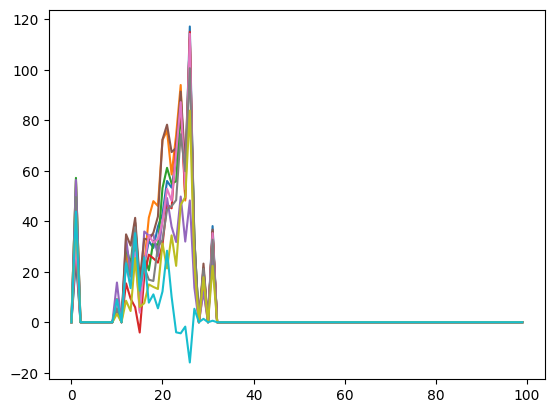

In [6]:
plt.plot(ng2['I', 0])
plt.show()

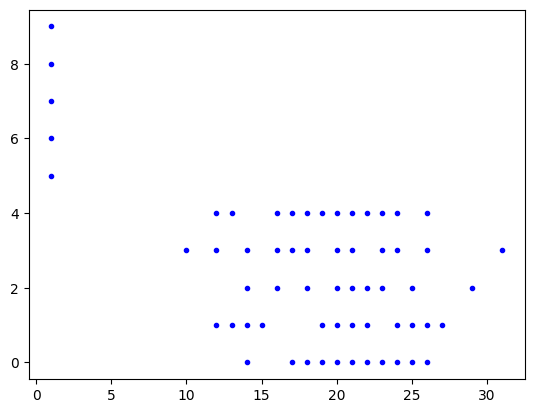

In [7]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")

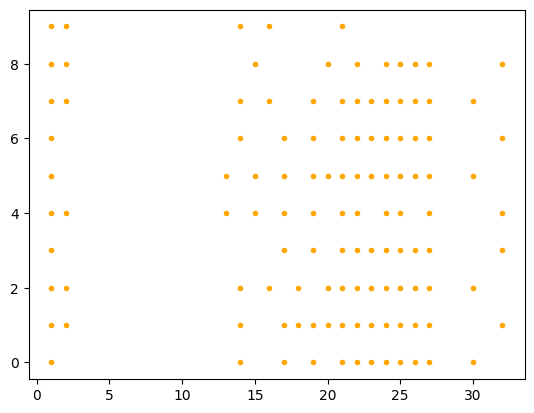

In [8]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "orange")

# spike-trace of input-layer

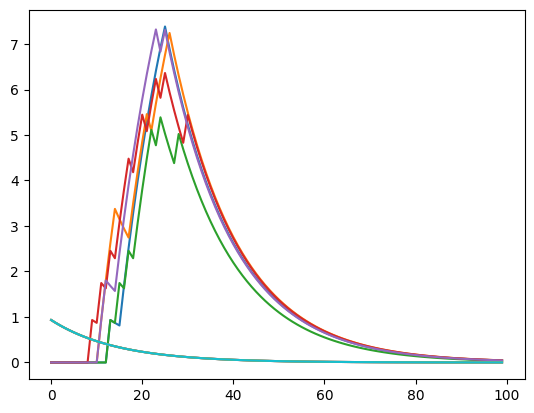

In [9]:
plt.plot(ng1['trace', 0])
plt.show()

# run multiple simulation

In [10]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 341 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
]) | ({
    800 : Recorder(["I"]),
}))

In [11]:
net.initialize()

for i in range(8) : 

    if(i < 4) : 
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3, 4]))
    else :
        ng1.add_behavior(341, PoissonGenerator(duration = 40, landa = 20, target=[5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)


Network['Network_1', 'Network'](Neurons: tensor(20)|2 groups, Synapses: tensor(100)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_dela

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 117.929ms
100xBatch: 1/1 (100%) 130.291ms
100xBatch: 1/1 (100%) 120.223ms
100xBatch: 1/1 (100%) 120.021ms
100xBatch: 1/1 (100%) 120.086ms
100xBatch: 1/1 (100%) 120.010ms
100xBatch: 1/1 (100%) 119.990ms


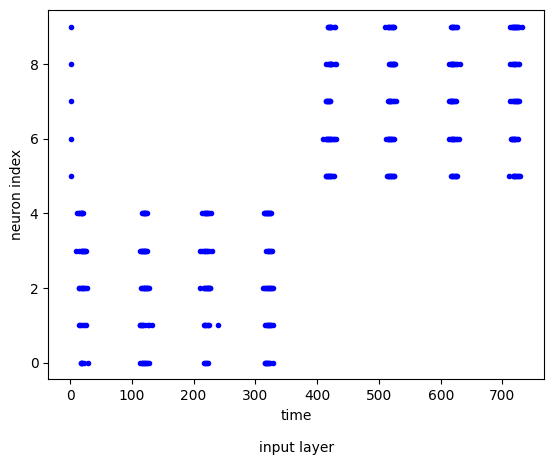

In [12]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.ylabel("neuron index")
plt.xlabel("time\n\ninput layer")
plt.show()

Text(0.5, 0, 'time\n\noutput layer')

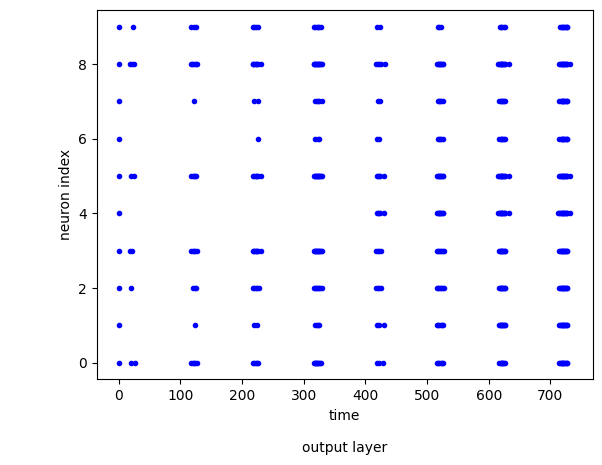

In [13]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")
plt.ylabel("\n\n\nneuron index")
plt.xlabel("time\n\noutput layer")

# Lateral Inhibition

In [14]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 342 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 2, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg1 = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
]) | ({
    800 : Recorder(["I", "weights"]),
}))

sg2 = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal,inh", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 0, 1]).view(1, 1, 1, 1, 3)),
    LateralDendriticInput(current_coef=60, inhibitory=True),
]) | ({
    800 : Recorder(["I"]),
}))

In [15]:
net.initialize()

for i in range(8) : 

    if(i < 4) : 
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3, 4, 5, 6, 7]))
    else :
        ng1.add_behavior(341, PoissonGenerator(duration = 40, landa = 20, target=[2, 3, 4, 5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

Network['Network_1', 'Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(24)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 175.278ms
100xBatch: 1/1 (100%) 164.999ms
100xBatch: 1/1 (100%) 208.367ms
100xBatch: 1/1 (100%) 255.077ms
100xBatch: 1/1 (100%) 255.010ms
100xBatch: 1/1 (100%) 299.993ms
100xBatch: 1/1 (100%) 237.897ms


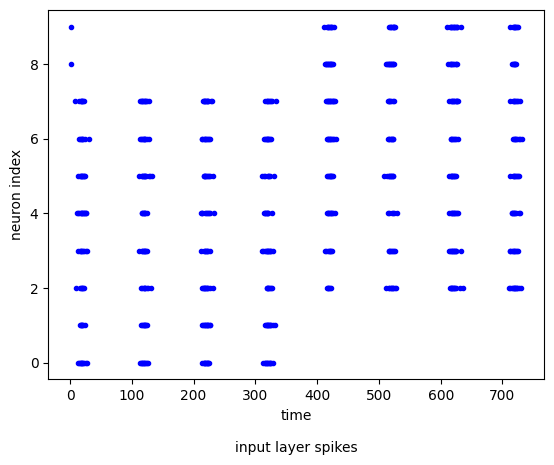

In [16]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.ylabel("neuron index")
plt.xlabel("time\n\ninput layer spikes")
plt.show()


# plt.plot(ng1["I", 0])
# plt.xlabel("time")
# plt.ylabel("I(t)")
# plt.show()

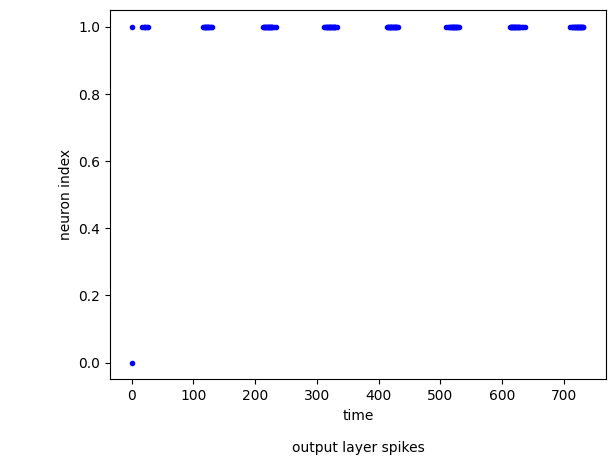

In [17]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")
plt.ylabel("\n\n\nneuron index")
plt.xlabel("time\n\noutput layer spikes")
plt.show()

Text(0, 0.5, 'I(t)')

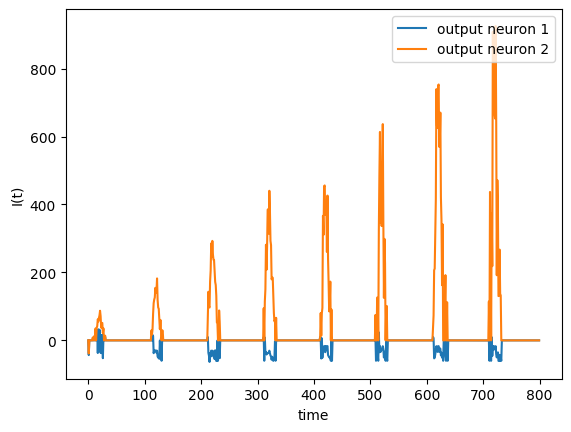

In [18]:
plt.plot(ng2["I", 0])
plt.legend(["output neuron 1", "output neuron 2"], loc="upper right")
plt.xlabel("time")
plt.ylabel("I(t)")

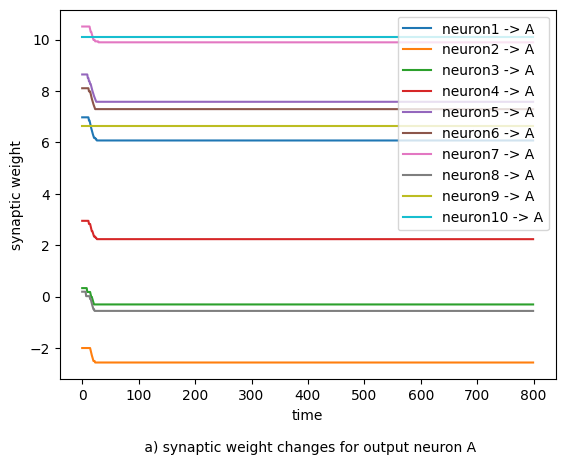

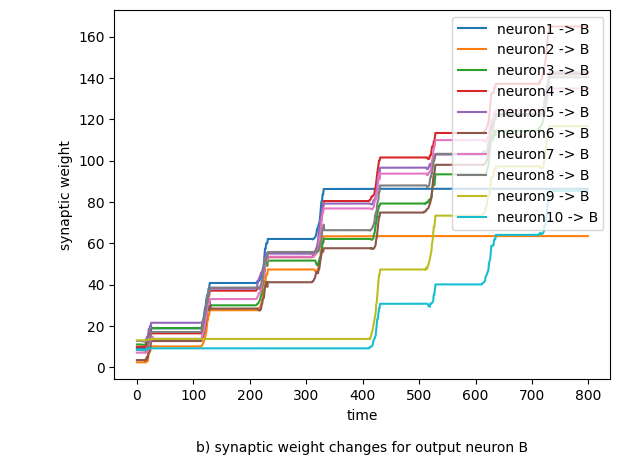

In [19]:
A = sg1["weights", 0][:,:,0]
B = sg1["weights", 0][:,:,1]

plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(10)], loc="upper right")
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(10)], loc="upper right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nb) synaptic weight changes for output neuron B")
plt.show()

# KWTA

In [20]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 10, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 342 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 2, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -20,
        v_rest = -65,
        v_reset = -70
    ),
    KWTA(k=1),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg1 = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(6, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 25,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
]) | ({
    800 : Recorder(["I", "weights"]),
}))

sg2 = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal,inh", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 0, 1]).view(1, 1, 1, 1, 3)),
    LateralDendriticInput(current_coef=10, inhibitory=True),
]) | ({
    800 : Recorder(["I"]),
}))

In [21]:
net.initialize()

for i in range(8) : 

    if(i < 4) : 
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3, 4, 5, 6]))
    else :
        ng1.add_behavior(341, PoissonGenerator(duration = 40, landa = 20, target=[3, 4, 5, 6, 7, 8, 9]))

    net.simulate_iterations(100)
    ng1.remove_behavior(341)

Network['Network_1', 'Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(24)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 180.224ms
100xBatch: 1/1 (100%) 245.939ms
100xBatch: 1/1 (100%) 286.934ms
100xBatch: 1/1 (100%) 262.056ms
100xBatch: 1/1 (100%) 290.686ms
100xBatch: 1/1 (100%) 260.806ms
100xBatch: 1/1 (100%) 262.499ms


Text(0.5, 0, 'time\n\ninput layer spikes')

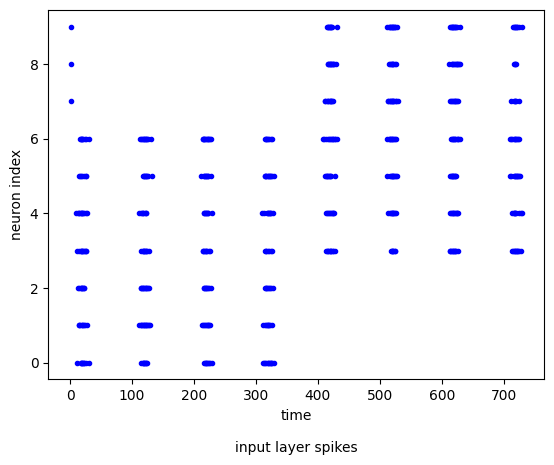

In [22]:
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.ylabel("neuron index")
plt.xlabel("time\n\ninput layer spikes")

Text(0.5, 0, 'time\n\noutput layer spikes')

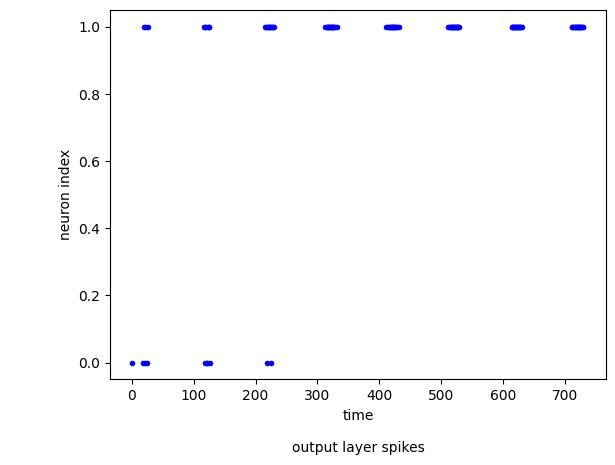

In [23]:
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")
plt.ylabel("\n\n\nneuron index")
plt.xlabel("time\n\noutput layer spikes")

Text(0, 0.5, 'I(t)')

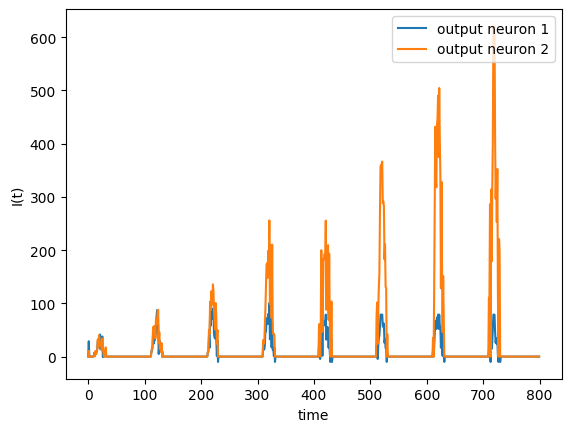

In [24]:
plt.plot(ng2["I", 0])
plt.legend(["output neuron 1", "output neuron 2"], loc="upper right")
plt.xlabel("time")
plt.ylabel("I(t)")

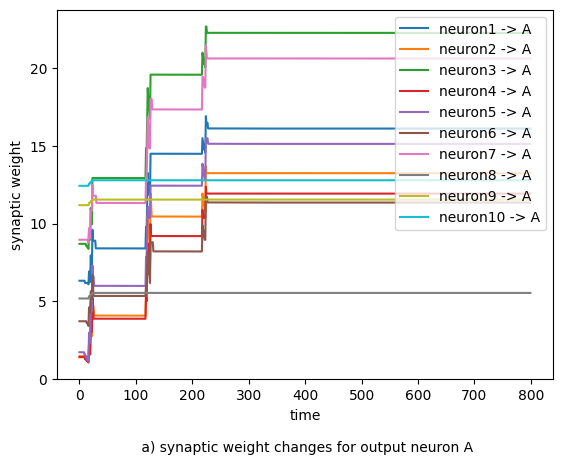

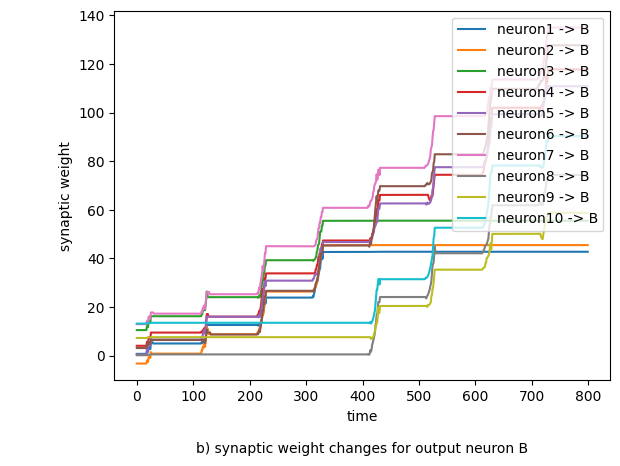

In [25]:
A = sg1["weights", 0][:,:,0]
B = sg1["weights", 0][:,:,1]

plt.plot(A)
plt.legend(["neuron{} -> A".format(i + 1) for i in range(10)], loc="upper right")
plt.ylabel("synaptic weight")
plt.xlabel("time\n\n a) synaptic weight changes for output neuron A")
plt.show()

plt.plot(B)
plt.legend(["neuron{} -> B".format(i + 1) for i in range(10)], loc="upper right")
plt.ylabel("\n\n\nsynaptic weight")
plt.xlabel("time\n\nb) synaptic weight changes for output neuron B")
plt.show()

# Homeostatis

### Voltage Base

In [26]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 20, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 342 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 5, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    VoltageBaseHomeostasis(target_voltage=-10, min_ta=-30, max_ta=-15, eta_ip=0.0003),
    KWTA(k=1),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg1 = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(5, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 20,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    WeightClip(w_min = 0, w_max = 20)
]) | ({
    800 : Recorder(["I", "weights"]),
}))

sg2 = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal,inh", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 1, 1, 1, 0, 1, 1, 1, 1]).view(1, 1, 1, 1, 9)),
    LateralDendriticInput(current_coef = 35, inhibitory=True),
]) | ({
    800 : Recorder(["I"]),
}))

In [27]:
net.initialize()

for _ in range(2) : 
    for i in range(25) : 

        if(i < 5) : 
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3])) #pattern, not target!
        elif(i < 10) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[4, 5, 6, 7]))
        elif(i < 15) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[8, 9, 10, 11]))
        elif(i < 20) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[12, 13, 14, 15]))
        else :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[16, 17, 18, 19]))

        net.simulate_iterations(100)
        ng1.remove_behavior(341)

ng2.remove_behavior(301)
net.simulate_iterations(300)
ng2.remove_behavior(400)

for i in range(5) : 

    if(i < 1) : 
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3]))
    elif(i < 2) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[4, 5, 6, 7]))
    elif(i < 3) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[8, 9, 10, 11]))
    elif(i < 4) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[12, 13, 14, 15]))
    else :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[16, 17, 18, 19]))
        
    net.simulate_iterations(100)
    ng1.remove_behavior(341)


Network['Network_1', 'Network'](Neurons: tensor(25)|2 groups, Synapses: tensor(125)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](20){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](5){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 225.733ms
100xBatch: 1/1 (100%) 251.657ms
100xBatch: 1/1 (100%) 501.099ms
100xBatch: 1/1 (100%) 408.573ms
100xBatch: 1/1 (100%) 294.036ms
100xBatch: 1/1 (100%) 411.889ms
100xBatch: 1/1 (100%) 642.924ms
100xBatch: 1/1 (100%) 501.072ms
100xBatch: 1/1 (100%) 405.802ms
100xBatch: 1/1 (100%) 323.993ms
100xBatch: 1/1 (100%) 509.990ms
100xBatch: 1/1 (100%) 517.333ms
100xBatch: 1/1 (100%) 421.361ms
100xBatch: 1/1 (100%) 305.238ms
100xBatch: 1/1 (100%) 340.768ms
100xBatch: 1/1 (100%) 263.095ms
100xBatch: 1/1 (100%) 271.586ms
100xBatch: 1/1 (100%) 316.367ms
100xBatch: 1/1 (100%) 253.268ms
100xBatch: 1/1 (100%) 327.062ms
100xBatch: 1/1 (100%) 254.995ms
100xBatch: 1/1 (100%) 333.256ms
100xBatch: 1/1 (100%) 240.010ms
100xBatch: 1/1 (100%) 269.990ms
100xBatch: 1/1 (100%) 313.464ms
100xBatch: 1/1 (100%) 300.756ms
100xBatch: 1/1 (100%) 269.999ms
100xBatch: 1/1 (100%) 270.001ms
100xBatch: 1/1 (100%) 476.249ms
100xBatch: 1/1 (100%) 285.001ms
100xBatch: 1/1 (100%) 270.252ms
100xBatc

Text(0, 0.5, 'neuron index')

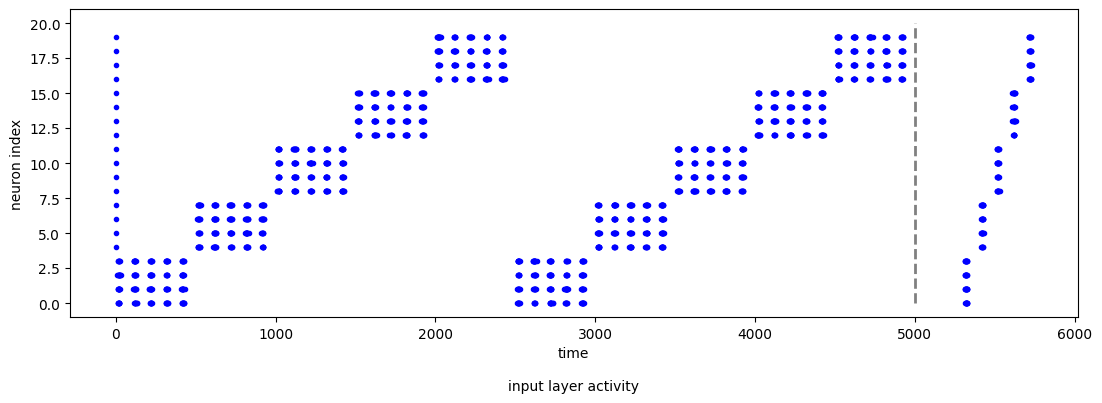

In [28]:
plt.figure(figsize=(13, 4))
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.vlines(x=5000, ymin=0, ymax=20, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\ninput layer activity")
plt.ylabel("neuron index")

Text(0, 0.5, 'neuron index')

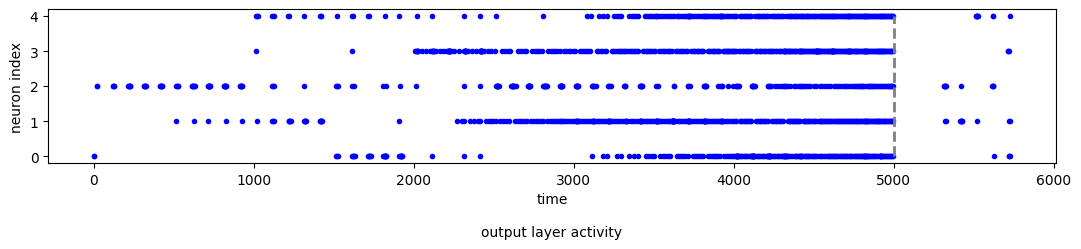

In [29]:
plt.figure(figsize=(13, 2))
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")
plt.vlines(x=5000, ymin=0, ymax=4, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\noutput layer activity")
plt.ylabel("neuron index")

Text(0, 0.5, 'I(t)')

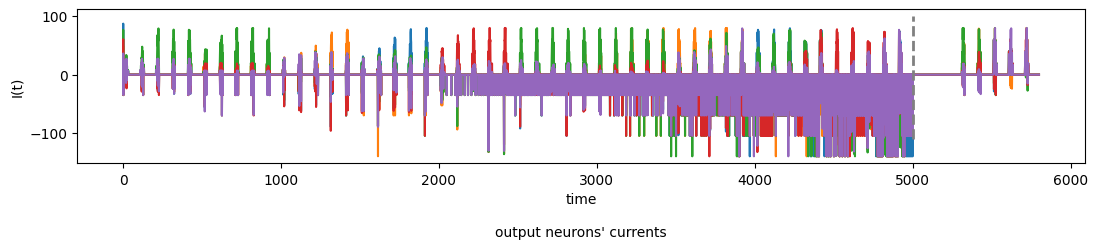

In [30]:
plt.figure(figsize=(13, 2))
plt.plot(ng2["I", 0])
plt.vlines(x=5000, ymin=-110, ymax=100, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\noutput neurons' currents")
plt.ylabel("I(t)")

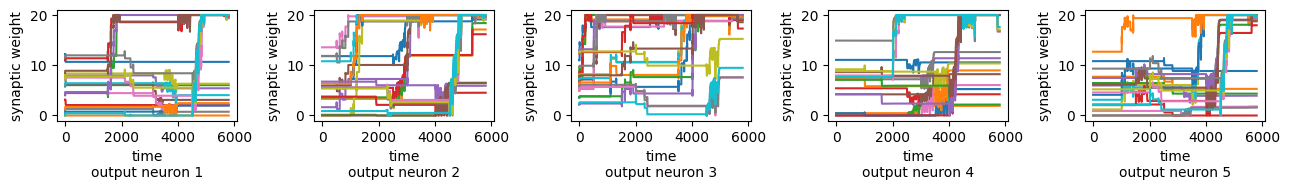

In [31]:
plt.figure(figsize=(13, 2))
for i in range(5) : 
    A = sg1["weights", 0][:,:,i]
    plt.subplot(1, 5, i + 1)
    plt.plot(A)
    plt.xlabel("time\noutput neuron {}".format(i+1))
    plt.ylabel("synaptic weight")

plt.tight_layout()
plt.show()

### Activity Base

In [32]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(),
]))

ng1 = NeuronGroup(size = 20, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 10,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    # 342 : PoissionGenerator(T = 40, lamda = 20),
    800 : Recorder(['v', "I", 'trace']),
    801 : EventRecorder(['spikes'])
}))

ng2 = NeuronGroup(size = 5, net = net, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
        tau = 7,
        R = 5,
        threshold = -13,
        v_rest = -65,
        v_reset = -70
    ),
    ActivityBaseHomeostasis(window_size=40, activity_rate=10, updating_rate=0.0001),
    KWTA(k=1),
    Fire(),
    SpikeTrace(tau_s = 15),
    NeuronAxon(),
]) | ({
    800 : Recorder(['v', "I", "trace"]),
    801 : EventRecorder(['spikes'])
}))

sg1 = SynapseGroup(net = net, src = ng1, dst = ng2, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(5, 4)"),
    SimpleDendriticInput(),
    SimpleSTDP(
        w_min = 0,
        w_max = 20,
        a_plus = 0.5,
        a_minus = 0.3,
    ),
    WeightClip(w_min = 0, w_max = 20)
]) | ({
    800 : Recorder(["I", "weights"]),
}))

sg2 = SynapseGroup(net = net, src = ng2, dst = ng2, tag = "Proximal,inh", behavior = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 1, 1, 1, 0, 1, 1, 1, 1]).view(1, 1, 1, 1, 9)),
    LateralDendriticInput(current_coef = 35, inhibitory=True),
]) | ({
    800 : Recorder(["I"]),
}))

In [33]:
net.initialize()

for _ in range(2) : 
    for i in range(25) : 

        if(i < 5) : 
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3]))
        elif(i < 10) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[4, 5, 6, 7]))
        elif(i < 15) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[8, 9, 10, 11]))
        elif(i < 20) :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[12, 13, 14, 15]))
        else :
            ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[16, 17, 18, 19]))

        net.simulate_iterations(100)
        ng1.remove_behavior(341)

ng2.remove_behavior(301)
net.simulate_iterations(300)
ng2.remove_behavior(400)

for i in range(5) : 

    if(i < 1) : 
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[0, 1, 2, 3]))
    elif(i < 2) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[4, 5, 6, 7]))
    elif(i < 3) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[8, 9, 10, 11]))
    elif(i < 4) :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[12, 13, 14, 15]))
    else :
        ng1.add_behavior(341, PoissonGenerator(duration = 50, landa = 20, target=[16, 17, 18, 19]))
        
    net.simulate_iterations(100)
    ng1.remove_behavior(341)


Network['Network_1', 'Network'](Neurons: tensor(25)|2 groups, Synapses: tensor(125)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](20){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=7,threshold=-13,v_reset=-70,v_rest=-65,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=15,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)800:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['v', 'I', 'trace'],)801:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](5){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay

C:\Users\USER\AppData\Local\Temp\ipykernel_17444\572522468.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  prob = ((landa**int(k))*np.exp(-landa))/np.math.factorial(int(k))


100xBatch: 1/1 (100%) 252.238ms
100xBatch: 1/1 (100%) 315.971ms
100xBatch: 1/1 (100%) 347.028ms
100xBatch: 1/1 (100%) 331.890ms
100xBatch: 1/1 (100%) 481.012ms
100xBatch: 1/1 (100%) 225.011ms
100xBatch: 1/1 (100%) 382.500ms
100xBatch: 1/1 (100%) 339.659ms
100xBatch: 1/1 (100%) 360.771ms
100xBatch: 1/1 (100%) 376.152ms
100xBatch: 1/1 (100%) 360.565ms
100xBatch: 1/1 (100%) 271.031ms
100xBatch: 1/1 (100%) 346.445ms
100xBatch: 1/1 (100%) 270.091ms
100xBatch: 1/1 (100%) 360.798ms
100xBatch: 1/1 (100%) 270.396ms
100xBatch: 1/1 (100%) 406.068ms
100xBatch: 1/1 (100%) 330.942ms
100xBatch: 1/1 (100%) 270.028ms
100xBatch: 1/1 (100%) 434.492ms
100xBatch: 1/1 (100%) 495.201ms
100xBatch: 1/1 (100%) 255.105ms
100xBatch: 1/1 (100%) 345.703ms
100xBatch: 1/1 (100%) 285.001ms
100xBatch: 1/1 (100%) 361.372ms
100xBatch: 1/1 (100%) 330.821ms
100xBatch: 1/1 (100%) 451.494ms
100xBatch: 1/1 (100%) 375.894ms
100xBatch: 1/1 (100%) 398.272ms
100xBatch: 1/1 (100%) 376.376ms
100xBatch: 1/1 (100%) 571.580ms
100xBatc

Text(0, 0.5, 'neuron index')

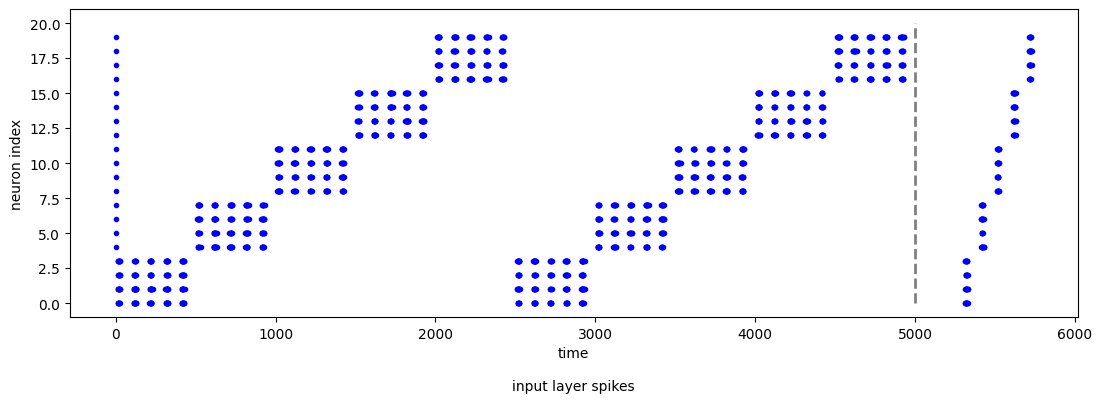

In [34]:
plt.figure(figsize=(13, 4))
plt.plot(ng1['spikes.t', 0], ng1['spikes.i', 0], '.', color = "blue")
plt.vlines(x=5000, ymin=0, ymax=20, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\ninput layer spikes")
plt.ylabel("neuron index")

Text(0, 0.5, 'neuron index')

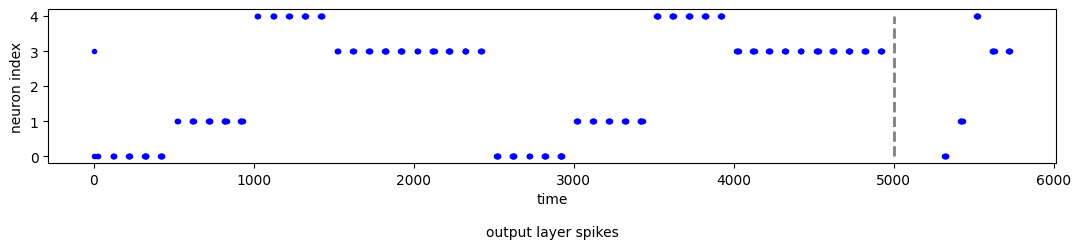

In [35]:
plt.figure(figsize=(13, 2))
plt.plot(ng2['spikes.t', 0], ng2['spikes.i', 0], '.', color = "blue")
plt.vlines(x=5000, ymin=0, ymax=4, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\noutput layer spikes")
plt.ylabel("neuron index")

Text(0, 0.5, 'I(t)')

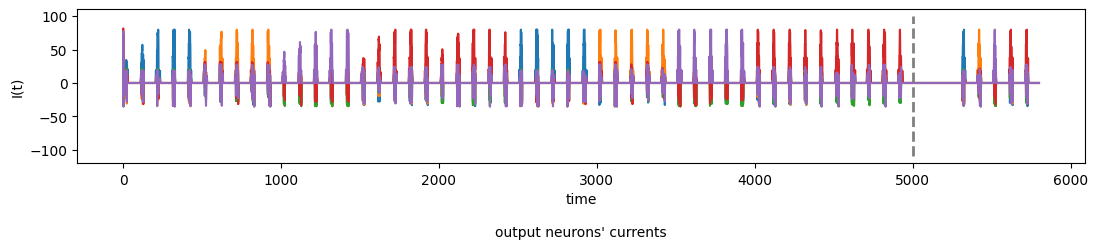

In [36]:
plt.figure(figsize=(13, 2))
plt.plot(ng2["I", 0])
plt.vlines(x=5000, ymin=-110, ymax=100, colors='gray', ls='--', lw=2, label='vline_multiple - full height')
plt.xlabel("time\n\noutput neurons' currents")
plt.ylabel("I(t)")

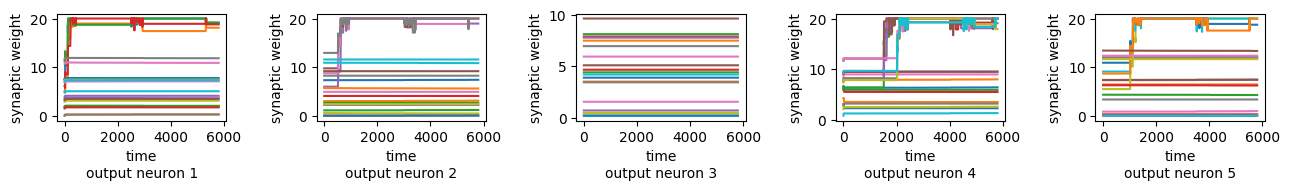

In [37]:
plt.figure(figsize=(13, 2))
for i in range(5) : 
    A = sg1["weights", 0][:,:,i]
    plt.subplot(1, 5, i + 1)
    plt.plot(A)
    plt.xlabel("time\noutput neuron {}".format(i+1))
    plt.ylabel("synaptic weight")

plt.tight_layout()
plt.show()